In [1]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import scipy.stats as sts
%matplotlib inline

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


In [5]:
#Среди channel_type есть пропущенные, я решила заполнить их дополнительным channel_type 'type_NA'
raw_df['channel_type'] =raw_df.channel_type.fillna(value = 'type_NA')
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,type_NA,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,type_NA,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,type_NA,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,type_NA,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,type_NA,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


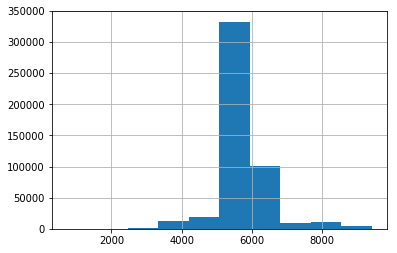

In [6]:
raw_df['MCC'].hist()

In [7]:
#не очень понятно, какие MCC популярные, но можно сказать, что визуально распределение похоже на нормальное

In [8]:
#Можно посмотреть топ-15 MCC
top_15_MCC=raw_df.groupby('MCC').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index().head(15)
top_15_MCC

,MCC,cl_id
0,5411,121640
1,6011,54382
2,5814,41351
3,5812,30027
4,5499,27237
5,5541,19816
6,5912,18728
7,5999,13073
8,6012,10056
9,5921,8578


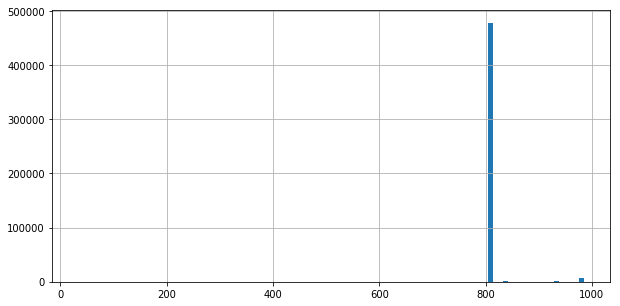

In [9]:
raw_df['currency'].hist(bins = 100,figsize=(10,5)) 

In [10]:
#Можно посмотреть топ-5 currency
top_5_currency=raw_df.groupby('currency').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index().head(5)
top_5_currency
#Рублевые операции - самые часто встречающиеся (как неожиданно)

,currency,cl_id
0,810,477644
1,978,5536
2,840,1921
3,933,561
4,985,423


In [11]:
#POS – оплата через POS терминал,  
#C2C_OUT – перевод на карту (исходящий платёж), 
#C2C_IN – перевод на карту (входящий платёж),  
#DEPOSIT – пополнение карты в банкомате, 
#WD_ATM_PARTNER – снятие наличных в банкоматах партнерах, 
#WD_ATM_ROS – снятие наличных в банкоматах Росбанка, 
#BACK_TRX – возврат средств при возврате покупки, 
#WD_ATM_OTHER – снятия в других банкоматах, 
#CAT – операции в банкоматах, 
#CASH_ADV – снятие карты в кассе банка.

In [12]:
#Топ trx_category
raw_df.groupby('trx_category').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index()
#С огромным перевесом лидируют pos транзакции. Это транзакции по банковской карте.

,trx_category,cl_id
0,POS,416425
1,DEPOSIT,21216
2,WD_ATM_ROS,19104
3,WD_ATM_PARTNER,9948
4,C2C_IN,7306
5,WD_ATM_OTHER,7140
6,C2C_OUT,5456
7,BACK_TRX,2687
8,CAT,1197
9,CASH_ADV,34


In [13]:
raw_df.groupby('trx_category').sum()[['amount']].sort_values('amount', ascending=False).reset_index()

,trx_category,amount
0,POS,1.013062e+09
1,WD_ATM_ROS,6.680845e+08
2,DEPOSIT,4.827459e+08
3,WD_ATM_PARTNER,3.327178e+08
4,C2C_IN,9.989715e+07
5,C2C_OUT,8.807488e+07
6,WD_ATM_OTHER,7.478062e+07
7,BACK_TRX,2.461917e+07
8,CAT,2.260286e+07
9,CASH_ADV,9.128249e+05


In [14]:
#И больше всего денег приходится на pos операции

In [15]:
#а теперь все тоже самое, количество и суммы по trx_category, но отдельно по неотточным и отточным

In [16]:
#отточные (target_flag=0)
raw_df[raw_df['target_flag']==0].groupby('trx_category').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index()

,trx_category,cl_id
0,POS,143428
1,DEPOSIT,11316
2,WD_ATM_ROS,5496
3,C2C_IN,3341
4,WD_ATM_PARTNER,2853
5,C2C_OUT,1786
6,BACK_TRX,1103
7,WD_ATM_OTHER,771
8,CAT,300
9,CASH_ADV,16


In [17]:
raw_df[raw_df['target_flag']==0].groupby('trx_category').sum()[['amount']].sort_values('amount', ascending=False).reset_index()

,trx_category,amount
0,POS,3.024480e+08
1,WD_ATM_ROS,2.644598e+08
2,DEPOSIT,2.059163e+08
3,WD_ATM_PARTNER,1.642713e+08
4,C2C_IN,4.359287e+07
5,C2C_OUT,3.092606e+07
6,BACK_TRX,1.095609e+07
7,WD_ATM_OTHER,6.468331e+06
8,CAT,5.811950e+06
9,CASH_ADV,5.247632e+05


In [18]:
#оставшиеся (target_flag=1)
raw_df[raw_df['target_flag']==1].groupby('trx_category').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index()

,trx_category,cl_id
0,POS,272997
1,WD_ATM_ROS,13608
2,DEPOSIT,9900
3,WD_ATM_PARTNER,7095
4,WD_ATM_OTHER,6369
5,C2C_IN,3965
6,C2C_OUT,3670
7,BACK_TRX,1584
8,CAT,897
9,CASH_ADV,18


In [19]:
raw_df[raw_df['target_flag']==1].groupby('trx_category').sum()[['amount']].sort_values('amount', ascending=False).reset_index()

,trx_category,amount
0,POS,7.106139e+08
1,WD_ATM_ROS,4.036246e+08
2,DEPOSIT,2.768296e+08
3,WD_ATM_PARTNER,1.684464e+08
4,WD_ATM_OTHER,6.831229e+07
5,C2C_OUT,5.714881e+07
6,C2C_IN,5.630428e+07
7,CAT,1.679091e+07
8,BACK_TRX,1.366308e+07
9,CASH_ADV,3.880618e+05


In [20]:
#Разница в суммах по видам операций между ушедшими и оставшимися
rf_count_trx_category_traget0=raw_df[raw_df['target_flag']==0].groupby('trx_category').count()[['cl_id']].sort_values('trx_category', ascending=True).reset_index()
rf_count_trx_category_traget1=raw_df[raw_df['target_flag']==1].groupby('trx_category').count()[['cl_id']].sort_values('trx_category', ascending=True).reset_index()
rf_count_trx_category_traget=rf_count_trx_category_traget0.merge(rf_count_trx_category_traget1, how = 'left', on = 'trx_category')
rf_count_trx_category_traget['diff']=rf_count_trx_category_traget['cl_id_y']-rf_count_trx_category_traget['cl_id_x']
rf_count_trx_category_traget['diff_part']=rf_count_trx_category_traget['diff']/rf_count_trx_category_traget['cl_id_x']
rf_count_trx_category_traget

,trx_category,cl_id_x,cl_id_y,diff,diff_part
0,BACK_TRX,1103,1584,481,0.436083
1,C2C_IN,3341,3965,624,0.186770
2,C2C_OUT,1786,3670,1884,1.054871
3,CASH_ADV,16,18,2,0.125000
4,CAT,300,897,597,1.990000
5,DEPOSIT,11316,9900,-1416,-0.125133
6,POS,143428,272997,129569,0.903373
7,WD_ATM_OTHER,771,6369,5598,7.260700
8,WD_ATM_PARTNER,2853,7095,4242,1.486856
9,WD_ATM_ROS,5496,13608,8112,1.475983


In [22]:
#У оставшихся в разы больше операций по снятию наличных, особенно по снятию наличных в других банках (WD_ATM_OTHER)

In [23]:
rf_sum_trx_category_traget0=raw_df[raw_df['target_flag']==0].groupby('trx_category').sum()[['amount']].sort_values('trx_category', ascending=True).reset_index()
rf_sum_trx_category_traget1=raw_df[raw_df['target_flag']==1].groupby('trx_category').sum()[['amount']].sort_values('trx_category', ascending=True).reset_index()
rf_sum_trx_category_traget=rf_sum_trx_category_traget0.merge(rf_sum_trx_category_traget1, how = 'left', on = 'trx_category')
rf_sum_trx_category_traget['diff']=rf_sum_trx_category_traget['amount_y']-rf_sum_trx_category_traget['amount_x']
rf_sum_trx_category_traget['diff_part']=rf_sum_trx_category_traget['diff']/rf_sum_trx_category_traget['amount_x']
rf_sum_trx_category_traget

,trx_category,amount_x,amount_y,diff,diff_part
0,BACK_TRX,1.095609e+07,1.366308e+07,2.706988e+06,0.247076
1,C2C_IN,4.359287e+07,5.630428e+07,1.271141e+07,0.291594
2,C2C_OUT,3.092606e+07,5.714881e+07,2.622275e+07,0.847917
3,CASH_ADV,5.247632e+05,3.880618e+05,-1.367014e+05,-0.260501
4,CAT,5.811950e+06,1.679091e+07,1.097896e+07,1.889032
5,DEPOSIT,2.059163e+08,2.768296e+08,7.091334e+07,0.344379
6,POS,3.024480e+08,7.106139e+08,4.081659e+08,1.349541
7,WD_ATM_OTHER,6.468331e+06,6.831229e+07,6.184396e+07,9.561038
8,WD_ATM_PARTNER,1.642713e+08,1.684464e+08,4.175150e+06,0.025416
9,WD_ATM_ROS,2.644598e+08,4.036246e+08,1.391648e+08,0.526223


In [24]:
#Интересно, что у оставшихся сумма по снятию наличных в других банках (WD_ATM_OTHER) в несколько раз выше ушедших
#Гипотеза:
#Предположим, что есть люди, у которых есть необходимость часто снимать деньги в банкоматах не Росбанка и не партнеров Росбанка.
#Обычно по таким операциям в дргуих банках есть какая-то комиссия, довольно существенная.
#Возможно людям, снимающим часто деньги в других банкоматах, все равно выгоднее обслуживаться в Росбанке. 
#И по этой причине, когда закончится период действия льготной карты, из-за этой выгоды они останутся.
#Вывод по этой гипотезе в самом конце.

In [25]:
#Топ channel_type
raw_df.groupby('channel_type').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index()

,channel_type,cl_id
0,type1,299247
1,type2,175013
2,type5,5587
3,type4,4476
4,type3,3280
5,type_NA,2910


In [26]:
import datetime

In [27]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df

In [28]:
#В какие дни недели какой клиент чаще всего совершал транзакции
Popular_trans_d_for_cl_id=transaction_by_day_count(raw_df)
Popular_trans_d_for_cl_id.head()

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,9,5.0,8.0,7.0,5.0,6.0,4.0,4.0
4,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0


In [29]:
#В какой день недели больше всего транзакций
Popular_trans_d_for_cl_id.sum()

day_of_transaction
cl_id    25561672.0
day_0       62114.0
day_1       65927.0
day_2       68509.0
day_3       69485.0
day_4       71458.0
day_5       78993.0
day_6       74027.0
dtype: float64

In [30]:
#больше всего совершается операций в субботу. Может люди чаще совершают оплаты картой (trx_category=POS) в субботу?

In [31]:
Popular_trans_d_for_cl_id_POS=transaction_by_day_count(raw_df[raw_df.trx_category=='POS'])
Popular_trans_d_for_cl_id_POS.head()

D:\Miniconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
1,1,5.0,20.0,19.0,16.0,16.0,10.0,15.0
2,5,14.0,16.0,14.0,7.0,19.0,19.0,22.0
3,9,5.0,4.0,5.0,4.0,4.0,3.0,4.0
4,10,67.0,29.0,43.0,59.0,55.0,47.0,74.0


In [32]:
Popular_trans_d_for_cl_id_POS.sum()

day_of_transaction
cl_id    25561672.0
day_0       55897.0
day_1       54598.0
day_2       57016.0
day_3       58084.0
day_4       59520.0
day_5       65654.0
day_6       65656.0
dtype: float64

In [33]:
#А нет, платят картами на выходных почти одинаково

In [34]:
#Если подумать, что сомнительно, что на отток клиентов будет влиять то, по каким дням они чаще совершают платежные операции

In [35]:
#Сгруппируем пользователей по сумма категорий транзакций и по их количеству.
#По крайней мере понимание, какими операциями клиенты пользуются чаще, и на какие операции 
#приходится основной денежный объем, поможет банку скорректировать предложения по банковским продуктам.

In [36]:
#На какой тип транзакций приходится самые большие суммы (по пользователяи)

In [37]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [38]:
df_agg_trx_category=get_aggregated_df(raw_df,'sum','trx_category').reset_index()
df_agg_trx_category.head()

trx_category,cl_id,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
0,0,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,1,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,5,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,9,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,10,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0


In [39]:
df_agg_count_trx_category=get_aggregated_df(raw_df,'count','trx_category').reset_index()
df_agg_count_trx_category.head()

trx_category,cl_id,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,trx_category_count_CAT,trx_category_count_DEPOSIT,trx_category_count_POS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS
0,0,0,0,1,0,0,1,3,0,0,0
1,1,0,0,0,0,0,2,101,0,0,1
2,5,1,0,8,0,0,4,111,2,2,14
3,9,0,3,0,0,0,1,29,0,1,5
4,10,0,1,19,0,3,24,374,0,3,39


In [40]:
df_agg_count_trx_category.sum()

trx_category
cl_id                                25561672
trx_category_count_BACK_TRX              2687
trx_category_count_C2C_IN                7306
trx_category_count_C2C_OUT               5456
trx_category_count_CASH_ADV                34
trx_category_count_CAT                   1197
trx_category_count_DEPOSIT              21216
trx_category_count_POS                 416425
trx_category_count_WD_ATM_OTHER          7140
trx_category_count_WD_ATM_PARTNER        9948
trx_category_count_WD_ATM_ROS           19104
dtype: int64

In [41]:
#Теперь можно сгруппировать пользователей по cl_id

In [42]:
raw_df_grouped=raw_df[['cl_id', 'target_flag']].groupby(['cl_id','target_flag']).sum().fillna(0).reset_index()
raw_df_grouped.head()

,cl_id,target_flag
0,0,0
1,1,0
2,5,1
3,9,0
4,10,0


In [43]:
#И соединить сгруппированные данные raw_df_grouped с df_agg_trx_category

In [44]:
new_df_grouped=raw_df_grouped.merge(df_agg_trx_category, how = 'left', on = 'cl_id')
new_df_grouped.head()

,cl_id,target_flag,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
0,0,0,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,1,0,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,5,1,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,9,0,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,10,0,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0


In [45]:
#И тут можно увидеть, на какую сумму у пользователя были операции с разбивкой по видам транзакций

In [73]:
#Вот это все мне просто жалко удалять, пусть побудет
#def transaction_by_month_count(dataset):
#    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
#        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%m')
#    ) 
#    tmp_df = dataset.groupby(
#        ['cl_id','day_of_transaction']
#    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
#    old_columns = [
#        old_col for old_col in tmp_df.columns.tolist()
#        if old_col in dataset['day_of_transaction'].unique()
#    ]
#    tmp_df.rename(
#        columns={old_col: 'month_' + old_col for old_col in old_columns},
#        inplace=True
#    )
#    return tmp_df

In [74]:
#Popular_trans_m_for_cl_id=transaction_by_month_count(raw_df)
#Popular_trans_m_for_cl_id.head()

In [46]:
#И соединить сгруппированные данные new_df_grouped с df_agg_count_trx_category

In [47]:
new_df_grouped=new_df_grouped.merge(df_agg_count_trx_category, how = 'left', on = 'cl_id')
new_df_grouped.head()

,cl_id,target_flag,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,...,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,trx_category_count_CAT,trx_category_count_DEPOSIT,trx_category_count_POS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS
0,0,0,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,...,0,0,1,0,0,1,3,0,0,0
1,1,0,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,...,0,0,0,0,0,2,101,0,0,1
2,5,1,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,...,1,0,8,0,0,4,111,2,2,14
3,9,0,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,...,0,3,0,0,0,1,29,0,1,5
4,10,0,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,...,0,1,19,0,3,24,374,0,3,39


In [77]:
#Тоже жалко, пусть останется
#здесь в channel_type количество операций на каждого пользователя всего
#raw_df_grouped_count=raw_df[['cl_id', 'channel_type']].groupby(['cl_id']).count().fillna(0).reset_index()
#raw_df_grouped_count.columns= ['cl_id','trans_count']
#raw_df_grouped_count.head()

In [78]:
#new_df_grouped_all=new_df_grouped.merge(Popular_trans_m_for_cl_id, how = 'left', on = 'cl_id')
#new_df_grouped_all.head()

In [79]:
#new_df_grouped_all=new_df_grouped_all.merge(raw_df_grouped_count, how = 'left', on = 'cl_id')
#new_df_grouped_all.head()

In [48]:
cl_ids_test = np.random.choice(new_df_grouped.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [49]:
# данные для обучения
transactions_train = new_df_grouped[~new_df_grouped.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# данные для теста
transactions_test = new_df_grouped[new_df_grouped.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  4000
Total transactions in test dataset:  1000


In [50]:
#Тестовые
X_test = transactions_test.drop(['cl_id','target_flag'], axis=1)
y_test = transactions_test['target_flag']

In [51]:
X_test.head(1)

,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,trx_category_count_CAT,trx_category_count_DEPOSIT,trx_category_count_POS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS
1,0.0,0.0,0.0,0.0,0.0,95000.0,122578.04,0.0,0.0,50000.0,0,0,0,0,0,2,101,0,0,1


In [52]:
y_test.head(1)

1    0
Name: target_flag, dtype: int64

In [53]:
#Train
X_train = transactions_train.drop(['cl_id','target_flag'], axis=1)
y_train = transactions_train['target_flag']

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [55]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [56]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train[cols], y_train)

In [57]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [58]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.8


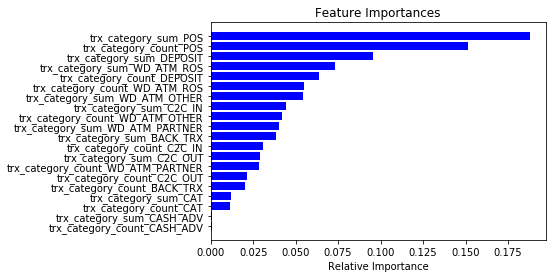

In [59]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [60]:
#Просто ради эксперимента сделать модель только на тех данных, где были операции по снятию с банкомата

In [61]:
new_df_grouped_WD_ATM=new_df_grouped[(new_df_grouped['trx_category_count_WD_ATM_OTHER']>=1) | (new_df_grouped['trx_category_count_WD_ATM_PARTNER']>=1) | (new_df_grouped['trx_category_count_WD_ATM_ROS']>=1)]
new_df_grouped_WD_ATM.head()

,cl_id,target_flag,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,...,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,trx_category_count_CAT,trx_category_count_DEPOSIT,trx_category_count_POS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS
1,1,0,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,...,0,0,0,0,0,2,101,0,0,1
2,5,1,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,...,1,0,8,0,0,4,111,2,2,14
3,9,0,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,...,0,3,0,0,0,1,29,0,1,5
4,10,0,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,...,0,1,19,0,3,24,374,0,3,39
6,14,1,0.0,152700.0,0.00,0.0,0.00,0.0,258990.17,0.0,...,0,3,0,0,0,0,132,0,0,1


In [62]:
new_df_grouped_WD_ATM.shape

(3337, 22)

In [65]:
cl_ids_test = np.random.choice(new_df_grouped_WD_ATM.cl_id.unique(), size=500, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [66]:
# данные для обучения
transactions_train = new_df_grouped_WD_ATM[~new_df_grouped_WD_ATM.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# данные для теста
transactions_test = new_df_grouped_WD_ATM[new_df_grouped_WD_ATM.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  2837
Total transactions in test dataset:  500


In [67]:
list(new_df_grouped_WD_ATM.columns)

['cl_id',
 'target_flag',
 'trx_category_sum_BACK_TRX',
 'trx_category_sum_C2C_IN',
 'trx_category_sum_C2C_OUT',
 'trx_category_sum_CASH_ADV',
 'trx_category_sum_CAT',
 'trx_category_sum_DEPOSIT',
 'trx_category_sum_POS',
 'trx_category_sum_WD_ATM_OTHER',
 'trx_category_sum_WD_ATM_PARTNER',
 'trx_category_sum_WD_ATM_ROS',
 'trx_category_count_BACK_TRX',
 'trx_category_count_C2C_IN',
 'trx_category_count_C2C_OUT',
 'trx_category_count_CASH_ADV',
 'trx_category_count_CAT',
 'trx_category_count_DEPOSIT',
 'trx_category_count_POS',
 'trx_category_count_WD_ATM_OTHER',
 'trx_category_count_WD_ATM_PARTNER',
 'trx_category_count_WD_ATM_ROS']

In [68]:
#Тестовые
X_test = transactions_test.drop(['cl_id','target_flag','trx_category_sum_BACK_TRX',\
                                'trx_category_sum_C2C_IN',\
                                'trx_category_sum_C2C_OUT',\
                                'trx_category_sum_CASH_ADV',\
                                'trx_category_sum_CAT',\
                                 'trx_category_sum_DEPOSIT',\
                                 'trx_category_sum_POS',
                                'trx_category_count_BACK_TRX',\
                                 'trx_category_count_C2C_IN',\
                                 'trx_category_count_C2C_OUT',\
                                 'trx_category_count_CASH_ADV',\
                                 'trx_category_count_CAT',\
                                 'trx_category_count_DEPOSIT',\
                                 'trx_category_count_POS',], axis=1)
y_test = transactions_test['target_flag']

In [69]:
X_test.head(1)

,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS
21,0.0,37100.0,251800.0,0,13,29


In [70]:
#Train
X_train = transactions_train.drop(['cl_id','target_flag','trx_category_sum_BACK_TRX',\
                                'trx_category_sum_C2C_IN',\
                                'trx_category_sum_C2C_OUT',\
                                'trx_category_sum_CASH_ADV',\
                                'trx_category_sum_CAT',\
                                 'trx_category_sum_DEPOSIT',\
                                 'trx_category_sum_POS',
                                'trx_category_count_BACK_TRX',\
                                 'trx_category_count_C2C_IN',\
                                 'trx_category_count_C2C_OUT',\
                                 'trx_category_count_CASH_ADV',\
                                 'trx_category_count_CAT',\
                                 'trx_category_count_DEPOSIT',\
                                 'trx_category_count_POS',], axis=1)
y_train = transactions_train['target_flag']

In [71]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [72]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train[cols], y_train)

In [73]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.99


In [74]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.7


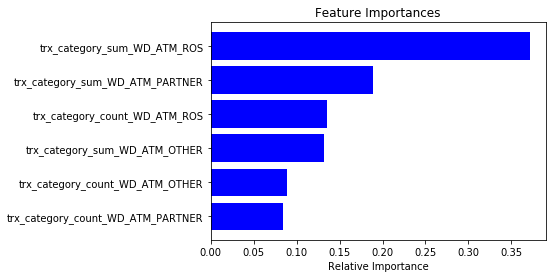

In [75]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [76]:
#Такая себе была идея, делать модель только исходя из данных по снятию с банкомата

In [77]:
#Можно попробовать на тех же данных, в которых есть хоть одно снятие с банкомата, но с учетом всех колонок
#Тестовые
X_test = transactions_test.drop(['cl_id','target_flag'], axis=1)
y_test = transactions_test['target_flag']

In [78]:
#Train
X_train = transactions_train.drop(['cl_id','target_flag'], axis=1)
y_train = transactions_train['target_flag']

In [79]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [80]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train[cols], y_train)

In [81]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [82]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.82


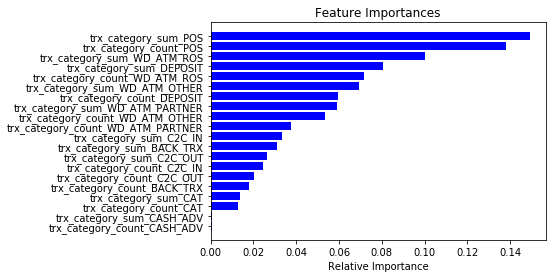

In [83]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [84]:
#Здесь у модели самые высокие результаты

In [85]:
#И последний вариант, где будут использованы только те данные, где точно были снятия с банкоматов не Росбанка или его партнеров

In [86]:
new_df_grouped_WD_ATM_OTHER=new_df_grouped[new_df_grouped['trx_category_count_WD_ATM_OTHER']>=1]
new_df_grouped_WD_ATM_OTHER.head()

,cl_id,target_flag,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,...,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,trx_category_count_CAT,trx_category_count_DEPOSIT,trx_category_count_POS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS
2,5,1,13990.0,0.0,33878.38,0.0,0.0,130000.0,290500.75,5500.0,...,1,0,8,0,0,4,111,2,2,14
9,22,0,0.0,0.0,0.00,0.0,500.0,122600.0,110267.00,3000.0,...,0,0,0,0,2,8,45,1,2,1
12,25,1,0.0,125000.0,0.00,0.0,0.0,0.0,11400.00,1035000.0,...,0,2,0,0,0,0,7,1,0,2
15,31,1,9900.0,0.0,0.00,0.0,0.0,0.0,393067.76,4800.0,...,1,0,0,0,0,0,99,1,5,1
16,32,1,0.0,48000.0,13000.00,0.0,0.0,0.0,136963.00,16000.0,...,0,4,2,0,0,0,116,4,3,4


In [87]:
new_df_grouped_WD_ATM_OTHER.shape

(1239, 22)

In [88]:
cl_ids_test = np.random.choice(new_df_grouped_WD_ATM.cl_id.unique(), size=300, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [89]:
# данные для обучения
transactions_train = new_df_grouped_WD_ATM[~new_df_grouped_WD_ATM.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# данные для теста
transactions_test = new_df_grouped_WD_ATM[new_df_grouped_WD_ATM.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  3037
Total transactions in test dataset:  300


In [90]:
#Тестовые
X_test = transactions_test.drop(['cl_id','target_flag'], axis=1)
y_test = transactions_test['target_flag']

In [91]:
#Train
X_train = transactions_train.drop(['cl_id','target_flag'], axis=1)
y_train = transactions_train['target_flag']

In [92]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [93]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train[cols], y_train)

In [94]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [95]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.84


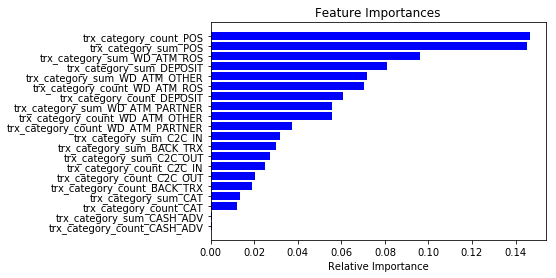

In [96]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [97]:
#Станет ли модель хуже, если убрать trx_category_WD_ATM_OTHER?

In [98]:
#Тестовые
X_test = transactions_test.drop(['cl_id','target_flag','trx_category_count_WD_ATM_OTHER','trx_category_sum_WD_ATM_OTHER']\
                                , axis=1)
y_test = transactions_test['target_flag']

In [99]:
#Train
X_train = transactions_train.drop(['cl_id','target_flag','trx_category_count_WD_ATM_OTHER','trx_category_sum_WD_ATM_OTHER']\
                                  , axis=1)
y_train = transactions_train['target_flag']

In [100]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [101]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train[cols], y_train)

In [102]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [103]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.84


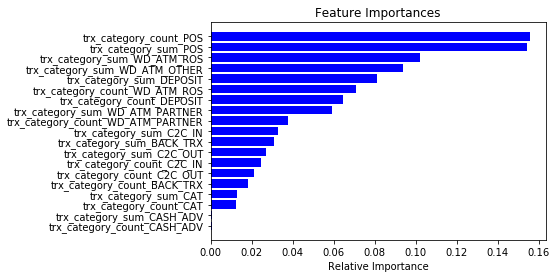

In [153]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [104]:
#Если строить модель на данных, где точно были снятия с других банкоматов, то trx_category_WD_ATM_OTHER повлияет на качество 
#модели. Но похоже, что исключение этого показателя вообще никак не будет влиять, если построить модель на всех данных
#но без этого показателя

In [105]:
cl_ids_test = np.random.choice(new_df_grouped.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [106]:
# данные для обучения
transactions_train = new_df_grouped[~new_df_grouped.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# данные для теста
transactions_test = new_df_grouped[new_df_grouped.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  4000
Total transactions in test dataset:  1000


In [107]:
#Тестовые
X_test = transactions_test.drop(['cl_id','target_flag','trx_category_count_WD_ATM_OTHER','trx_category_sum_WD_ATM_OTHER']\
                                , axis=1)
y_test = transactions_test['target_flag']

In [108]:
#Train
X_train = transactions_train.drop(['cl_id','target_flag','trx_category_count_WD_ATM_OTHER','trx_category_sum_WD_ATM_OTHER']\
                                  , axis=1)
y_train = transactions_train['target_flag']

In [109]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [110]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train[cols], y_train)

In [111]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [112]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.8


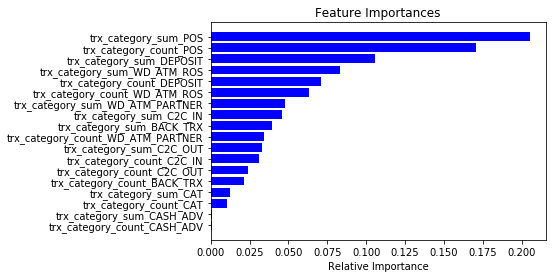

In [113]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [114]:
#Тот неловкий момент, когда исключение фичи, которая казалось важной, никак не повлияло на модель)
#Видимо в случае, если строить модель на выборке, где есть значения по снятию денег с дургих банкоматов, то фичи, связанные
#c WD_ATM_OTHER будут иметь значение. Но для предсказания оттока на полных данных эти фичи не будут положительно влиять 
#на качество модели.Значит гипотеза не подтвердилась.